In [1]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import zoom

def read_dicom_series(directory):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(directory)
    reader.SetFileNames(dicom_names)
    image = reader.Execute()

    # If the image is multi-component (e.g., RGB), convert it to grayscale
    if image.GetNumberOfComponentsPerPixel() > 1:
        channels = [sitk.VectorIndexSelectionCast(image, i) for i in range(image.GetNumberOfComponentsPerPixel())]
        image = sum(channels) / len(channels)

    image = sitk.Cast(image, sitk.sitkFloat32)

    return image

# Update the paths to the directories containing your DICOM series
primary_ct_directory = r'D:\CTH_archive\PN1'
tmax_overlay_directory = r'D:\CTH_archive\TEST_TMAX'
fixed_image_directory = r'D:\CTH_archive\CTH_DICOM_SINGLE_FILES'

primary_ct_image = read_dicom_series(primary_ct_directory)
tmax_overlay_image = read_dicom_series(tmax_overlay_directory)
fixed_image = read_dicom_series(fixed_image_directory)

In [2]:
moving_image = primary_ct_image

In [3]:
# Initialize the registration method
registration_method = sitk.ImageRegistrationMethod()

# Compute the centers of the images
fixed_center = np.array(fixed_image.TransformContinuousIndexToPhysicalPoint(np.array(fixed_image.GetSize()) / 2.0))
moving_center = np.array(moving_image.TransformContinuousIndexToPhysicalPoint(np.array(moving_image.GetSize()) / 2.0))

# Compute the translation needed to align the centers
translation = sitk.TranslationTransform(fixed_image.GetDimension())
translation.SetOffset(np.array(fixed_center - moving_center))

# Initialize the affine transform with the computed translation
affine_transform = sitk.AffineTransform(fixed_image.GetDimension())
affine_transform.SetTranslation(translation.GetOffset())


# Improved metric, optimizer, and interpolator settings
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingPercentage(0.4, sitk.sitkWallClock)  # Increased sampling percentage
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)

registration_method.SetOptimizerAsGradientDescentLineSearch(learningRate=0.5, numberOfIterations=1000, convergenceMinimumValue=1e-6, convergenceWindowSize=20)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Enhanced multi-resolution strategy
registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[16, 8, 4, 2])  # Added more levels
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[5, 4, 2, 1])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Ensure the initial transform is correctly set
registration_method.SetInitialTransform(affine_transform)

# Execute the affine registration with refined settings
final_transform = registration_method.Execute(fixed_image, moving_image)

# Resample using the final transform
resampled_CTH_CTP_Registrion = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

In [4]:
# Get the size and spacing of the primary CT image
primary_size = primary_ct_image.GetSize()
primary_spacing = primary_ct_image.GetSpacing()

# Calculate the new spacing for the Tmax overlay to match the primary CT size
overlay_new_spacing = [osz*ospz/psz for osz, ospz, psz in zip(tmax_overlay_image.GetSize(), tmax_overlay_image.GetSpacing(), primary_size)]

# Resample the Tmax overlay to match the primary CT size
resample_filter = sitk.ResampleImageFilter()
resample_filter.SetSize(primary_size)
resample_filter.SetOutputSpacing(overlay_new_spacing)
resample_filter.SetInterpolator(sitk.sitkLinear)
resample_filter.SetOutputDirection(primary_ct_image.GetDirection())
resample_filter.SetOutputOrigin(primary_ct_image.GetOrigin())

# Execute the resampling
resized_tmax_overlay = resample_filter.Execute(tmax_overlay_image)


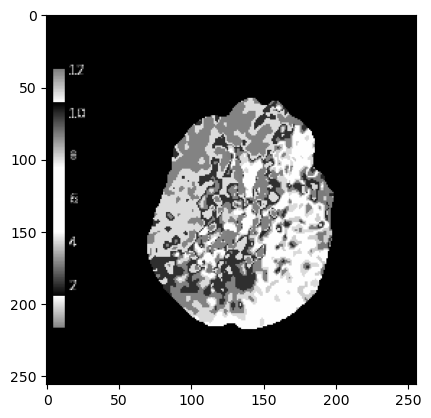

In [5]:
tmax_overlay_np = sitk.GetArrayFromImage(tmax_overlay_image)
cropped_tmax_overlay_np = tmax_overlay_np[:, 30:, :]
plt.imshow(cropped_tmax_overlay_np[15, :, :], cmap='gray')

In [6]:
# Initialize the array to hold the resized slices
resized_slices = np.empty((cropped_tmax_overlay_np.shape[0], 512, 512), dtype=cropped_tmax_overlay_np.dtype)

for i in range(cropped_tmax_overlay_np.shape[0]):  # Loop through slices
    resized_slices[i, :, :] = zoom(cropped_tmax_overlay_np[i, :, :], (512 / 256, 512 / 256), order=2)

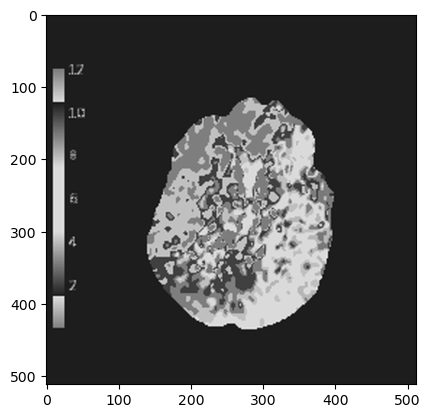

In [7]:
plt.imshow(resized_slices[15, :, :], cmap= 'gray')

In [8]:
cropped_tmax_overlay = sitk.GetImageFromArray(cropped_tmax_overlay_np)
spacing = cropped_tmax_overlay.GetSpacing()  # Spacing between pixels/voxels in each dimension
direction = cropped_tmax_overlay.GetDirection()  # Direction cosine matrix
origin = cropped_tmax_overlay.GetOrigin()  # The x, y, z coordinates of the image origin
size = cropped_tmax_overlay.GetSize()  # Number of pixels/voxels in each dimension

# Print the information
print("Spacing:", spacing)
print("Direction:", direction)
print("Origin:", origin)
print("Size:", size)

Spacing: (1.0, 1.0, 1.0)
Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Origin: (0.0, 0.0, 0.0)
Size: (256, 256, 23)


In [9]:
# Now, extract and print the relevant metadata
spacing = primary_ct_image.GetSpacing()  # Spacing between pixels/voxels in each dimension
direction = primary_ct_image.GetDirection()  # Direction cosine matrix
origin = primary_ct_image.GetOrigin()  # The x, y, z coordinates of the image origin
size = primary_ct_image.GetSize()  # Number of pixels/voxels in each dimension

# Print the information
print("Spacing:", spacing)
print("Direction:", direction)
print("Origin:", origin)
print("Size:", size)


Spacing: (0.429688, 0.429688, 5.0)
Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Origin: (-105.3, -116.7, -49.75)
Size: (512, 512, 23)


In [10]:
desired_spacing = (0.429688, 0.429688, 5.0)
desired_origin = (-105.3, -116.7, -49.75)
desired_size = (512, 512, 23)  # Note: Changing size might require resampling

# Create a new image with the desired properties
new_image = sitk.Image(desired_size, cropped_tmax_overlay.GetPixelID())
new_image.SetSpacing(desired_spacing)
new_image.SetOrigin(desired_origin)
new_image.SetDirection(cropped_tmax_overlay.GetDirection())  # Keeping the original direction

# To adjust the size, you might need to resample the original image
resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(new_image)  # Use the new image as reference for its properties
resampler.SetInterpolator(sitk.sitkLinear)  # Choose an interpolation method
resampler.SetTransform(sitk.Transform())  # Use identity transform

# Resample the original image
resampled_image = resampler.Execute(cropped_tmax_overlay)

# Now 'resampled_image' has the desired spacing, origin, and size
# You can check the properties to confirm
print("New Spacing:", resampled_image.GetSpacing())
print("New Origin:", resampled_image.GetOrigin())
print("New Size:", resampled_image.GetSize())

New Spacing: (0.429688, 0.429688, 5.0)
New Origin: (-105.3, -116.7, -49.75)
New Size: (512, 512, 23)


In [11]:
# Now, extract and print the relevant metadata
spacing_CTP_RAW = fixed_image.GetSpacing()  # Spacing between pixels/voxels in each dimension
direction_CTP_RAW = fixed_image.GetDirection()  # Direction cosine matrix
origin_CTP_RAW = fixed_image.GetOrigin()  # The x, y, z coordinates of the image origin
size_CTP_RAW = fixed_image.GetSize()  # Number of pixels/voxels in each dimension

# Print the information
print("Spacing:", spacing_CTP_RAW)
print("Direction:", direction_CTP_RAW)
print("Origin:", origin_CTP_RAW)
print("Size:", size_CTP_RAW)

Spacing: (0.449219, 0.449219, 5.412)
Direction: (1.0, 0.0, 0.0, 0.0, 0.9238797538373538, 0.38268289803626016, 0.0, -0.38268289803626016, 0.9238797538373538)
Origin: (-109.3, -132.646, -8.938)
Size: (512, 512, 32)


In [59]:
cropped_tmax_overlay = sitk.GetImageFromArray(cropped_tmax_overlay_np)


resampler = sitk.ResampleImageFilter()

# Manually set the output size and spacing as desired
resampler.SetSize((512, 512, 32))
resampler.SetOutputSpacing((0.5, 0.5, 1))
resampler.SetOutputDirection((1, 0, 0, 0, 1, 0, 0, 0, 1))
cropped_tmax_overlay.SetOrigin((0, 0, 0))
#resampler.SetSize(size_CTP_RAW)
#resampler.SetOutputSpacing(spacing_CTP_RAW)
#resampler.SetOutputOrigin(origin_CTP_RAW)
#resampler.SetOutputDirection(direction_CTP_RAW)

# Set the new translation back to the transformation
#final_transform.SetTranslation(new_translation)

resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetTransform(final_transform)

transformed_cropped_tmax_overlay = resampler.Execute(cropped_tmax_overlay)


In [60]:
# Define the path for the output NIfTI file
output_file_path = r"D:\CTH_archive\output_image.nii"

# Save the SimpleITK image as a NIfTI file
sitk.WriteImage(transformed_cropped_tmax_overlay, output_file_path)


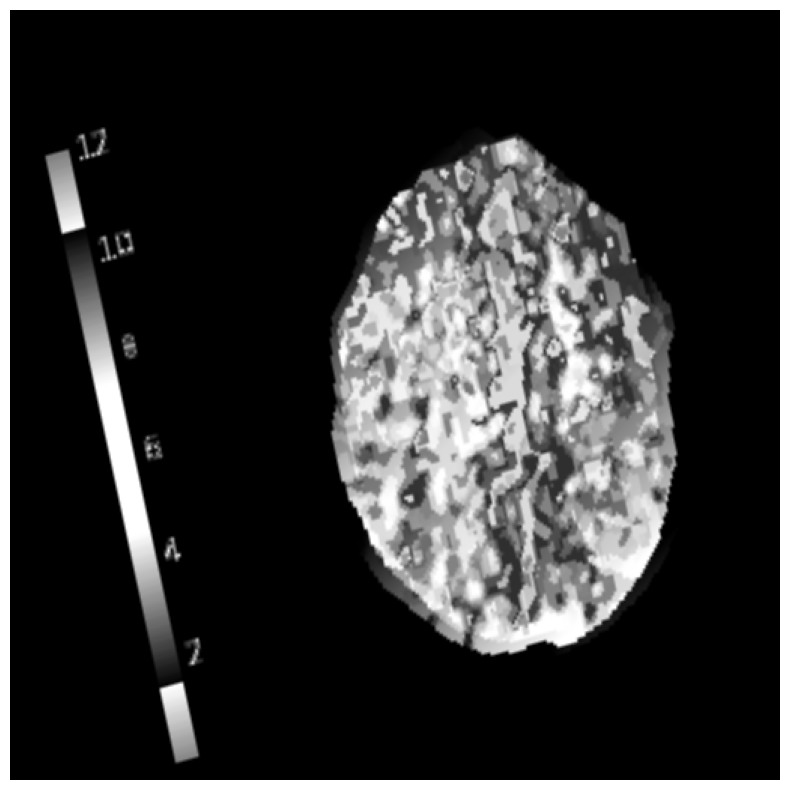

In [61]:
transformed_image_np = sitk.GetArrayFromImage(transformed_cropped_tmax_overlay)
# Select the middle slice index in the Z-axis
slice_index = transformed_image_np.shape[0] // 2

# Plot the selected slice
plt.figure(figsize=(10, 10))
plt.imshow(transformed_image_np[slice_index], cmap='gray')
plt.axis('off')  # Optional: remove axes for a cleaner image
plt.show()

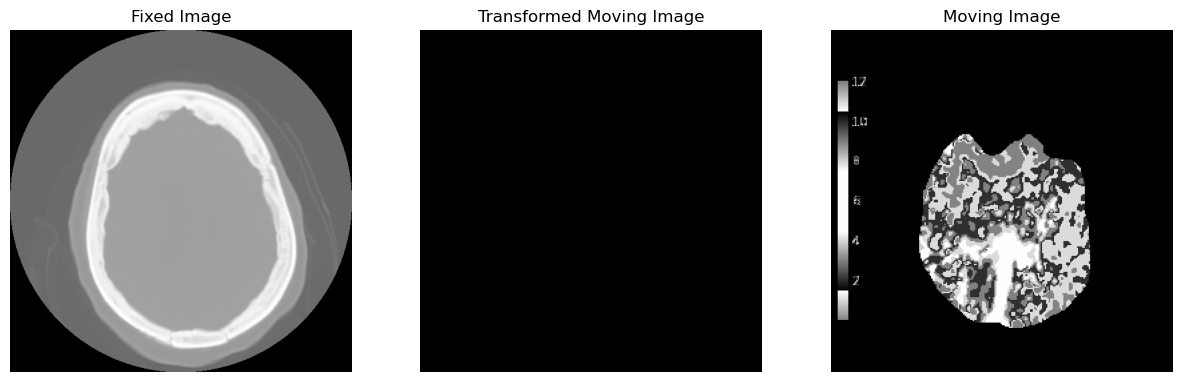

In [56]:
def display_images(fixed_image, moving_image, transformed_image):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(sitk.GetArrayFromImage(fixed_image)[fixed_image.GetSize()[2]//2], cmap='gray')
    axs[0].set_title('Fixed Image')
    
    axs[1].imshow(sitk.GetArrayFromImage(transformed_image)[transformed_image.GetSize()[2]//2], cmap='gray')
    axs[1].set_title('Transformed Moving Image')

    axs[2].imshow(sitk.GetArrayFromImage(moving_image)[moving_image.GetSize()[2]//2], cmap='gray')
    axs[2].set_title('Moving Image')

    for ax in axs:
        ax.axis('off')

    plt.show()
display_images(fixed_image, cropped_tmax_overlay, transformed_cropped_tmax_overlay)

In [72]:
import nibabel as nib
import numpy as np

# Load the NIfTI file
nii = nib.load(r'D:\CTH_archive\output_image.nii')

# Get the image data and affine matrix
image_data = nii.get_fdata()
affine_matrix = nii.affine
x_translation, y_translation, z_translation = 0, 128, 0
# Example adjustment: apply a translation within the affine matrix
translation_vector = [x_translation, y_translation, z_translation]  # Define your translations
new_affine_matrix = affine_matrix.copy()
new_affine_matrix[:3, 3] += translation_vector  # Apply translation to the affine matrix

# Create a new NIfTI image with the adjusted affine matrix
new_nii = nib.Nifti1Image(image_data, new_affine_matrix)

# Save the adjusted image
nib.save(new_nii, r'D:\CTH_archive\transformed_image.nii')


In [73]:
nifti_image = nib.load(r"D:\CTH_archive\transformed_image.nii")

# Get the header
header = nifti_image.header

# Print voxel dimensions (includes x, y, and z spacing)
print("Voxel dimensions:", header.get_zooms())

Voxel dimensions: (0.5, 0.5, 1.0)


In [74]:
import SimpleITK as sitk

# Paths to the fixed and moving images
fixed_image_path = r"D:\CTH_archive\CTP_RAW.nii"
moving_image_path = r"D:\CTH_archive\output_image.nii"

# Read the fixed and moving images
fixed_image = sitk.ReadImage(fixed_image_path)
moving_image = sitk.ReadImage(moving_image_path)

# Prepare a list to hold the slices from the moving image
new_image_slices = []

# Assuming both images have the same number of slices
for z in range(fixed_image.GetSize()[2]):  # Iterate through each slice
    # Extract the corresponding slice from the moving image
    moving_slice = moving_image[:,:,z]
    
    # Add the moving slice to the list
    new_image_slices.append(moving_slice)

# Stack the slices from the moving image to form a new 3D image
new_image = sitk.JoinSeries(new_image_slices)

# Copy the metadata from the fixed image to the new image
new_image.SetOrigin(fixed_image.GetOrigin())
new_image.SetSpacing(fixed_image.GetSpacing())
new_image.SetDirection(fixed_image.GetDirection())

# Define the output path for the new image
output_image_path = r"D:\CTH_archive\new_image.nii"

# Save the new image
sitk.WriteImage(new_image, output_image_path)
